In [1]:
import datasets
from huggingface_hub import login
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

2024-05-08 11:49:56.861295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 11:49:56.861421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 11:49:57.035382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset = datasets.load_dataset("Gapes21/vqa2", split = "train", streaming = True)

In [4]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

In [5]:
N = 10
images, labels = [], []
ct = 0
for item in dataset:
    if ct >= 10:
        break
    images.append(item["image"])
    labels.append(item["answer"])
    ct += 1
    
images = processor(images = images, return_tensors="pt")['pixel_values']
labelEncoder = LabelEncoder()
labelEncoder.fit(labels)
labels = labelEncoder.transform(labels)

data = (images, labels)

In [6]:
class DinoBasedClassifier(nn.Module):
    def __init__(
        self, 
        C,
        hidden_dim = 10,
        d3 = 16, 
        d4 = 16, 
        num_heads = 8, 
        num_layers = 3
    ):
        super(DinoBasedClassifier, self).__init__()
        self.C, self.d1, self.d2, self.d3, self.d4, self.num_heads, self.num_layers = C, 257, 768, d3, d4, num_heads, num_layers
#         self.processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        # output : [N * patches * hidden_dim] = [N * d1 * d2], patches = 16 * 16 + 1
        self.reshaper = nn.Linear(self.d1 * self.d2, self.d3 * self.d4)
        encoder_layer = nn.TransformerEncoderLayer(d_model = d4, nhead = num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        # output : [N * d3 * d4]
        self.fc1 = nn.Linear(d3 * d4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, C)
        
    def forward(self, x):
#         x = self.processor(images = images, return_tensors="pt")
        out = self.dino(x)
        x = out.last_hidden_state
        
        x = x.view(x.shape[0], -1)
        x = self.reshaper(x)
        x = x.view(x.shape[0], self.d3, self.d4)
        
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        
        return x

In [7]:
model = DinoBasedClassifier(10)

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
output = model(images)

In [21]:
labels = [output[i].argmax().item() for i in range(len(output))]
labels

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [11]:
def train(data, model, metric, optimizer, num_epochs = 2):
    loss_list = []
    for epoch in tqdm(range(num_epochs)):
        x, y = data
        optimizer.zero_grad()
        out = model(x)
        loss = metric(out,torch.tensor(y))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    plt.plot(loss_list)

100%|██████████| 20/20 [08:19<00:00, 25.00s/it]


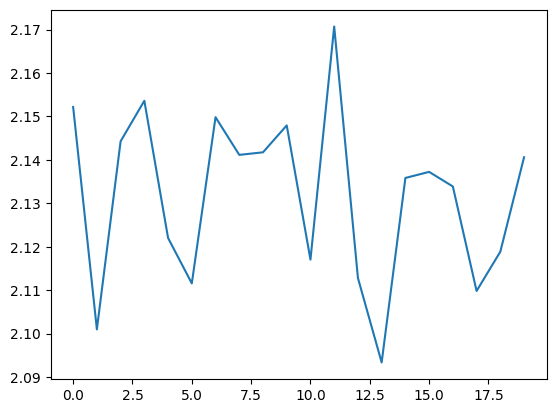

In [22]:
train(data, model, loss, optimizer, 20)

In [23]:
output = model(images)

In [24]:
labels = [output[i].argmax().item() for i in range(len(output))]

In [27]:
labelEncoder.inverse_transform(labels)

array(['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no'],
      dtype='<U24')